In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.getcwd())
cwd = os.getcwd()
# Any results you write to the current directory are saved as output.

/content


In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
cd /gdrive/My\ Drive/lab_project02

/gdrive/My Drive/lab_project02


In [4]:
ls -l

total 99134
drwx------ 2 root root      4096 Sep 16 07:27 18.09.16(custom_model_tb)/
-rw------- 1 root root 101250544 Sep 16 07:27 final_model_VGG.h5
drwx------ 2 root root      4096 Aug 30 01:15 last_img_data/
-rw------- 1 root root     42188 Sep 16 05:23 model(18_08_28).ipynb
-rw------- 1 root root    207784 Sep 16 07:26 model_InceptionResNetV2.ipynb
drwx------ 2 root root      4096 Sep 14 08:18 split_data/


In [5]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Dense,Dropout,Softmax,Input,Flatten
from keras.optimizers import Adam,RMSprop,SGD
from keras.layers.merge import add
from keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import BatchNormalization
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator, load_img

from IPython.display import display
from  PIL import Image

Using TensorFlow backend.


In [0]:
# dimensions of our images.
img_width, img_height = 579, 238
# img_width, img_height = 150, 150 # VGG 적용

In [0]:
train_data_dir = './split_data/train'
validation_data_dir = './split_data/val'
test_data_dir = './split_data/test'
# validation_data_dir = cwd + '/chest_xray/val'
# test_data_dir = cwd + '/chest_xray/test'

# nb_train_samples = 5217
# nb_validation_samples = 17
epochs = 20
batch_size = 8

In [0]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [0]:
train_datagen = ImageDataGenerator(rescale=1. / 255)

In [0]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [0]:
validation_datagen = ImageDataGenerator(rescale=1. / 255)

In [30]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 6397 images belonging to 8 classes.


In [31]:
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 800 images belonging to 8 classes.


In [32]:
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 800 images belonging to 8 classes.


In [0]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2

In [0]:
InceptionResNetV2_model = InceptionResNetV2(include_top=True, input_shape=(579, 238, 3), classes=8, weights=None)

In [17]:
InceptionResNetV2_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 579, 238, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 289, 118, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 289, 118, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 289, 118, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [0]:
from keras.models import Model
from keras.preprocessing import image

In [19]:
model = Model(InceptionResNetV2_model.input, output=InceptionResNetV2_model.get_layer('predictions').output)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(Tensor("in..., outputs=Tensor("pr...)`
  """Entry point for launching an IPython kernel.


In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics=['accuracy']) # if single-label classification

In [0]:
import keras.backend.tensorflow_backend as K
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

In [0]:
# checkpoint = ModelCheckpoint("test_audio_model.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
# early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')
tb = TensorBoard(log_dir='18.09.16(custom_model_tb)')

In [0]:
checkpoint = ModelCheckpoint("InceptionResNetV2_model.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

In [24]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11523514803450614796
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11281989632
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1432572083021454512
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [33]:
with K.tf.device('/gpu:0'):
    hist = model.fit_generator(
        train_generator,
        validation_data = validation_generator,
        epochs = epochs,
        callbacks = [tb, checkpoint, early]
    )

Epoch 1/20
800/800 [==============================] - 1219s 2s/step - loss: 1.8434 - acc: 0.3150 - val_loss: 2.2390 - val_acc: 0.2350

Epoch 00001: val_acc improved from -inf to 0.23500, saving model to final_model_VGG.h5
Epoch 2/20
800/800 [==============================] - 1181s 1s/step - loss: 1.6677 - acc: 0.3875 - val_loss: 1.6128 - val_acc: 0.4338

Epoch 00002: val_acc improved from 0.23500 to 0.43375, saving model to final_model_VGG.h5
Epoch 3/20
800/800 [==============================] - 1181s 1s/step - loss: 1.5924 - acc: 0.4320 - val_loss: 1.6165 - val_acc: 0.4575

Epoch 00003: val_acc improved from 0.43375 to 0.45750, saving model to final_model_VGG.h5
Epoch 4/20
800/800 [==============================] - 1180s 1s/step - loss: 1.5403 - acc: 0.4477 - val_loss: 1.7500 - val_acc: 0.3588

Epoch 00004: val_acc did not improve from 0.45750
Epoch 5/20
800/800 [==============================] - 1179s 1s/step - loss: 1.4963 - acc: 0.4736 - val_loss: 1.6299 - val_acc: 0.4175

Epoch 00

In [34]:
# evaluate the model
scores = model.evaluate_generator(test_generator)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


acc: 35.12%


In [0]:
from keras.models import load_model
model = load_model('InceptionResNetV2_valchack_model.h5')

In [36]:
# evaluate the saved model
scores = model.evaluate_generator(test_generator)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


acc: 54.00%


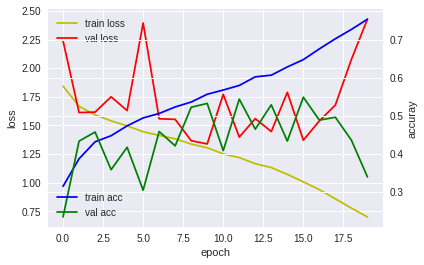

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [0]:
model.save_weights('InceptionResNetV2_weights(18_09_15).h5')